In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

from network.nerformer import NerFormerArchitecture
from network.feature_network import FeatureNetArchitecture

from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from rendering import render_rays
from utils import *


def data_to_frame_test(co3d_data, device, tgt_idx, src_idxs):
    imgs = co3d_data.image_rgb.to(torch.float16).to(device)
    img_paths = co3d_data.image_path
    masks = co3d_data.fg_probability.to(torch.float16).to(device)
    camera = co3d_data.camera.to(device)
    camera.R = camera.R.to(torch.float16)
    camera.T = camera.T.to(torch.float16)
    print(camera.R.dtype)
    print(camera.T.dtype)
    
    target = {}
    target["rgb"] = imgs[tgt_idx]
    target["rgb_path"] = img_paths[tgt_idx]
    target["mask"] = masks[tgt_idx]
    target["camera"] = camera
    # 현재 타겟 카메라의 위치를 기준으로
    # 샘플링할 ray들의 depth range 계산
    
    target_camera_position = camera.get_camera_center()[tgt_idx]
    near = torch.norm(target_camera_position) - 8
    far = torch.norm(target_camera_position) + 8
    depth_range =  torch.tensor([near, far], dtype=torch.float32)
    target["depth_range"] = depth_range

    srcs = {}
    srcs["rgb"] = imgs[src_idxs]
    srcs["mask"] = masks[src_idxs]

    return target, srcs



class FeatureNet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.feature_net = FeatureNetArchitecture()
    

    def forward(self, x):
        feature = self.feature_net(x)

        return feature



class NerFormerTest(pl.LightningModule):
    def __init__(self, d_z, args):
        super().__init__()

        # NerFormer
        self.nerformer = NerFormerArchitecture(d_z)
        # Image Feature Net
        self.feature_net = FeatureNet()
        self.feature_net.freeze()
        # Positional Embedding
        self.PE = HarmonicEmbedding(n_harmonic_functions=args.pe_dim)
        self.args = args

    def forward(self, x):
        output = self.nerformer(x)

        return output

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.nerformer.parameters(), lr=0.0005)

        return optimizer


    def training_step(self, train_batch, batch_idx):
        target_idx = 0
        sources = [src_idx for src_idx in range(1, args.N_src + 1)]

        # dataloader 아이템에서 targe과 source를 정의
        target, srcs = data_to_frame_test(train_batch, args.device, target_idx, sources)

        # source 이미지로부터 iamge feature 추출
        self.feature_net.eval()
        with torch.no_grad():
            feature_maps = self.feature_net(srcs["rgb"], srcs["mask"])

        # target 이미지에서 학습 rays 샘플링
        ray_sampler = RaySampler(target, target_idx, args.device, args)
        ray_batch = ray_sampler.random_sample(args.N_rays, args.ray_sampling_mode)

        # Inference
        output = render_rays(ray_batch, net, net, feature_maps, sources, args)

        coarse_rgb_loss = mse_loss(output["outputs_coarse"]["rgb"], ray_batch["rgb"])
        # coarse_mask_loss = bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])
        self.log('coarse_rgb_loss', coarse_rgb_loss)

        fine_rgb_loss = mse_loss(output["outputs_fine"]["rgb"], ray_batch["rgb"])
        # fine_mask_loss = bce_loss(output["outputs_fine"]["mask"][..., 0], ray_batch["mask"])
        self.log('fine_rgb_loss', fine_rgb_loss)

        total_loss = coarse_rgb_loss + fine_rgb_loss
        self.log('train_loss', total_loss)

        return loss


    def validation_step(self, val_batch, val_idx):
        target_idx = 0
        sources = [src_idx for src_idx in range(1, args.N_src + 1)]


        # dataloader 아이템에서 targe과 source를 정의
        target, srcs = data_to_frame_test(val_batch, args.device, target_idx, sources)

        # source 이미지로부터 iamge feature 추출
        with torch.no_grad():
            feature_maps = feature_net(srcs["rgb"], srcs["mask"])

        # target 이미지에서 학습 rays 샘플링
        ray_sampler = RaySampler(target, target_idx, args.device, args)
        ray_batch = ray_sampler.random_sample(args.N_rays, args.ray_sampling_mode)

        # Inference
        output = render_rays(ray_batch, net, net, feature_maps, sources, args)

        coarse_rgb_loss = mse_loss(output["outputs_coarse"]["rgb"], ray_batch["rgb"])
        # coarse_mask_loss = bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])
        self.log('val_coarse_rgb_loss', coarse_rgb_loss)

        fine_rgb_loss = mse_loss(output["outputs_fine"]["rgb"], ray_batch["rgb"])
        # fine_mask_loss = bce_loss(output["outputs_fine"]["mask"][..., 0], ray_batch["mask"])
        self.log('val_fine_rgb_loss', fine_rgb_loss)

        total_loss = coarse_rgb_loss + fine_rgb_loss
        self.log('val_loss', total_loss)


In [5]:
import pytorch_lightning as pl
from network.model import NerFormer


category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )


dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
        batch_size=(args.N_src + 1),
        # num_workers=2,
        dataset_len=1000,
        dataset_len_val=10,
        images_per_seq_options=[100],
    )

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [30]:
# model
model = NerFormerTest(160, args)

# training
trainer = pl.Trainer(gpus=1, num_nodes=0, precision=16, limit_train_batches=0.5)
trainer.fit(model, train_loader, val_loader)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                  | Params
------------------------------------------------------
0 | nerformer   | NerFormerArchitecture | 164 K 
1 | feature_net | FeatureNet            | 8.2 M 
2 | PE          | HarmonicEmbedding     | 0     
------------------------------------------------------
164 K     Trainable params
8.2 M     Non-trainable params
8.3 M     Total params
16.698    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/M2020802/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


torch.float16
torch.float16


RuntimeError: Half did not match Float

In [1]:
import time
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch3d
from tensorboardX import SummaryWriter

from co3d.dataset.dataset_zoo import dataset_zoo
from co3d.dataset.dataloader_zoo import dataloader_zoo

from network.nerformer import NerFormerArchitecture
from network.feature_network import FeatureNetArchitecture

from positional_embedding import HarmonicEmbedding
from ray_sampling import RaySampler
from rendering import render_rays

from utils import *

In [2]:
from omegaconf import OmegaConf

args = OmegaConf.load("config_file.yaml")
print(args)

{'root_dir': './', 'exp_name': 'config_test', 'device': 'cuda', 'N_src': 3, 'N_src_extra': 10, 'N_rays': 800, 'pe_dim': 10, 'lr': 0.0005, 'n_iters': 100000, 'chunk_size': 3200, 'N_samples': 32, 'N_importance': 16, 'inv_uniform': True, 'det': True, 'render_stride': 1, 'ray_sampling_mode': 'uniform', 'center_ratio': 0.8, 'log_img': 2000, 'log_loss': 100, 'log_weight': 5000}


save directory 경로 설정 및 생성

In [3]:
out_folder = os.path.join(args.root_dir, 'out', args.exp_name)
print('outputs will be saved to {}'.format(out_folder))
os.makedirs(out_folder, exist_ok=True)

outputs will be saved to ./out/config_test


In [4]:
# 현재 config setting 저장

f = os.path.join(out_folder, 'args.txt')
with open(f, 'w') as file:
    OmegaConf.save(config=args, f=file.name)

dataset, dataloader 생성

In [5]:
category = "teddybear"
task = "singlesequence"
single_sequence_id = 0

datasets = dataset_zoo(
        category=category,
        assert_single_seq=task == "singlesequence",
        dataset_name=f"co3d_{task}",
        test_on_train=False,
        load_point_clouds=False,
        test_restrict_sequence_id=single_sequence_id,
    )


dataloaders = dataloader_zoo(
        datasets,
        dataset_name=f"co3d_{task}",
        batch_size=(args.N_src + args.N_src_extra),
        # num_workers=2,
        dataset_len=1000,
        dataset_len_val=10,
        images_per_seq_options=[100],
    )

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

set_names_mapping :{'train': ['test_known'], 'val': ['test_known', 'test_unseen'], 'test': ['test_known', 'test_unseen']}
Dataset :  train
subsets :  ['test_known']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known']' subsets.
pick_sequence: ['34_1479_4753']
... filtered 75 -> 1
CO3D Dataset #frames=81
Dataset :  val
subsets :  ['test_known', 'test_unseen']
Loading Co3D frames from ../dataset/CO3D/teddybear/frame_annotations.jgz.
Loading Co3D sequences from ../dataset/CO3D/teddybear/sequence_annotations.jgz.
Loading Co3D subset lists from ../dataset/CO3D/teddybear/set_lists.json.
Removing images with empty masks.
... filtered 72865 -> 63135
Limitting Co3D dataset to the '['test_known', 'test_unseen']' subset

In [5]:
print(datasets["train"].__len__())
print(datasets["val"].__len__())
print(datasets["test"].__len__())


81
102
102


In [6]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1000
10
100


In [51]:
datasets["train"]

Co3dDataset(frame_annotations_file='../dataset/CO3D/teddybear/frame_annotations.jgz', sequence_annotations_file='../dataset/CO3D/teddybear/sequence_annotations.jgz', subset_lists_file='../dataset/CO3D/teddybear/set_lists.json', subsets=['test_known'], limit_to=-1, limit_sequences_to=-1, pick_sequence=['34_1479_4753'], exclude_sequence=[], limit_category_to=[], dataset_root='../dataset/CO3D', load_images=True, load_depths=True, load_depth_masks=True, load_masks=True, load_point_clouds=False, max_points=0, mask_images=False, mask_depths=False, image_height=800, image_width=800, box_crop=True, box_crop_mask_thr=0.4, box_crop_context=0.3, remove_empty_masks=True, n_frames_per_sequence=-1, seed=0, eval_batches=None)

torch.Size([13, 3, 800, 800]) torch.Size([13, 4, 4])
12
[11  1  6 12  4  8  2  7  9 10  3  5]


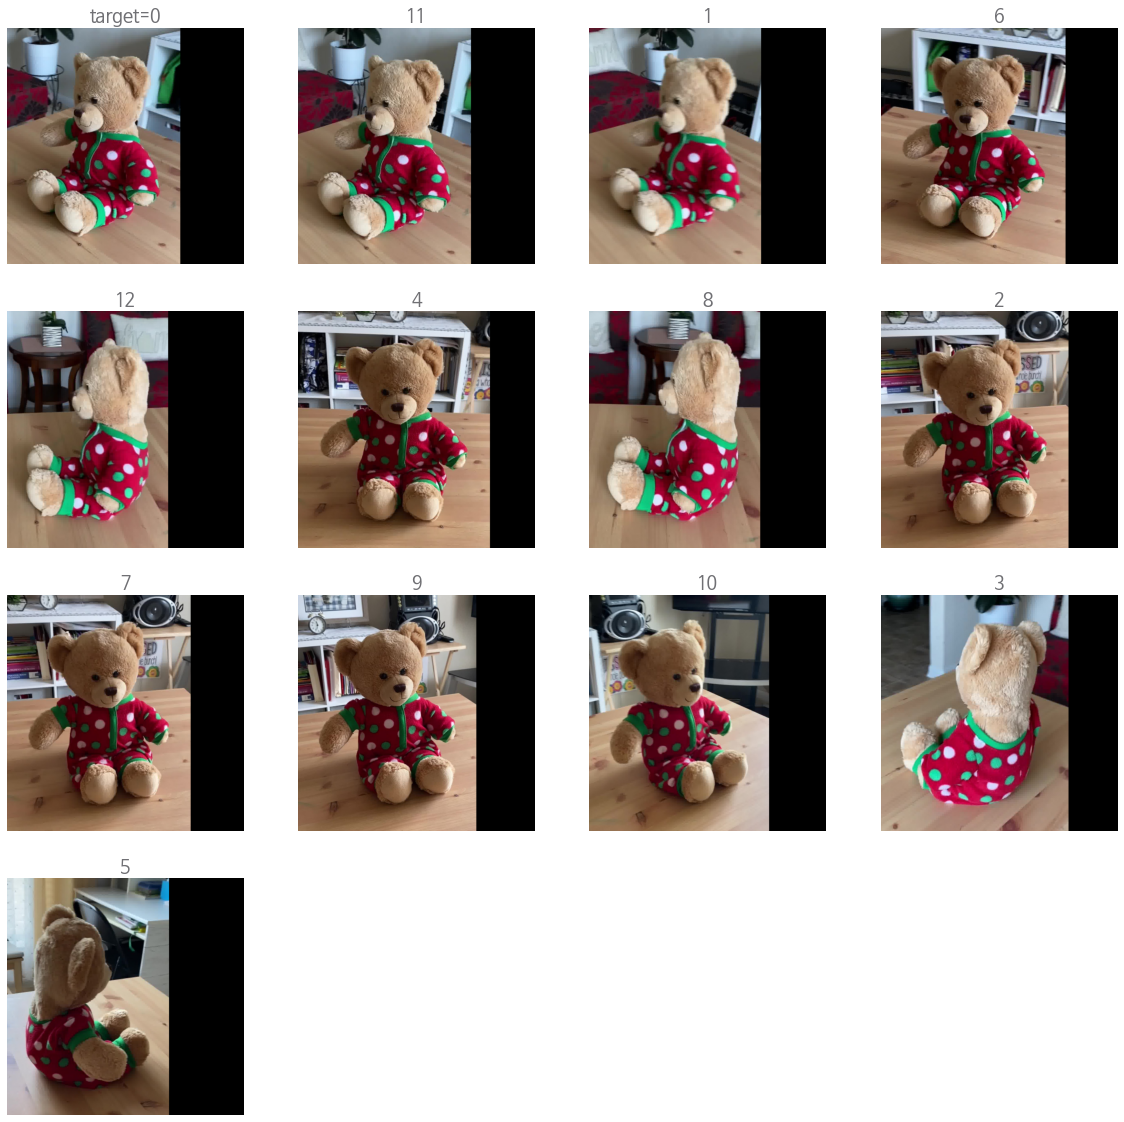

In [10]:
data = next(iter(train_loader))

rgbs = data.image_rgb
cameras = data.camera
c2ws = cameras.get_world_to_view_transform().inverse().get_matrix()

print(rgbs.shape, c2ws.shape)


tgt_idx = 0
tgt_c2w = c2ws[tgt_idx]
src_c2ws = c2ws[1:]
print(len(src_c2ws))

src_idxs = get_nearest_src(tgt_c2w, src_c2ws, 12, angular_dist_method="matrix") + 1

print(src_idxs)

plt.figure(figsize=(20, 20))

tgt_img = rgbs[tgt_idx]
src_imgs = rgbs[src_idxs]

plt.subplot(4, 4, 1)
plt.title("target=0")
img = tgt_img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.axis("off")

for i, src_img in enumerate(src_imgs):
    plt.subplot(4, 4, 2 + i)
    plt.title(src_idxs[i])
    img = src_img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")

tensor([11,  1,  6, 12,  4,  8,  2,  7,  9, 10,  3,  5])


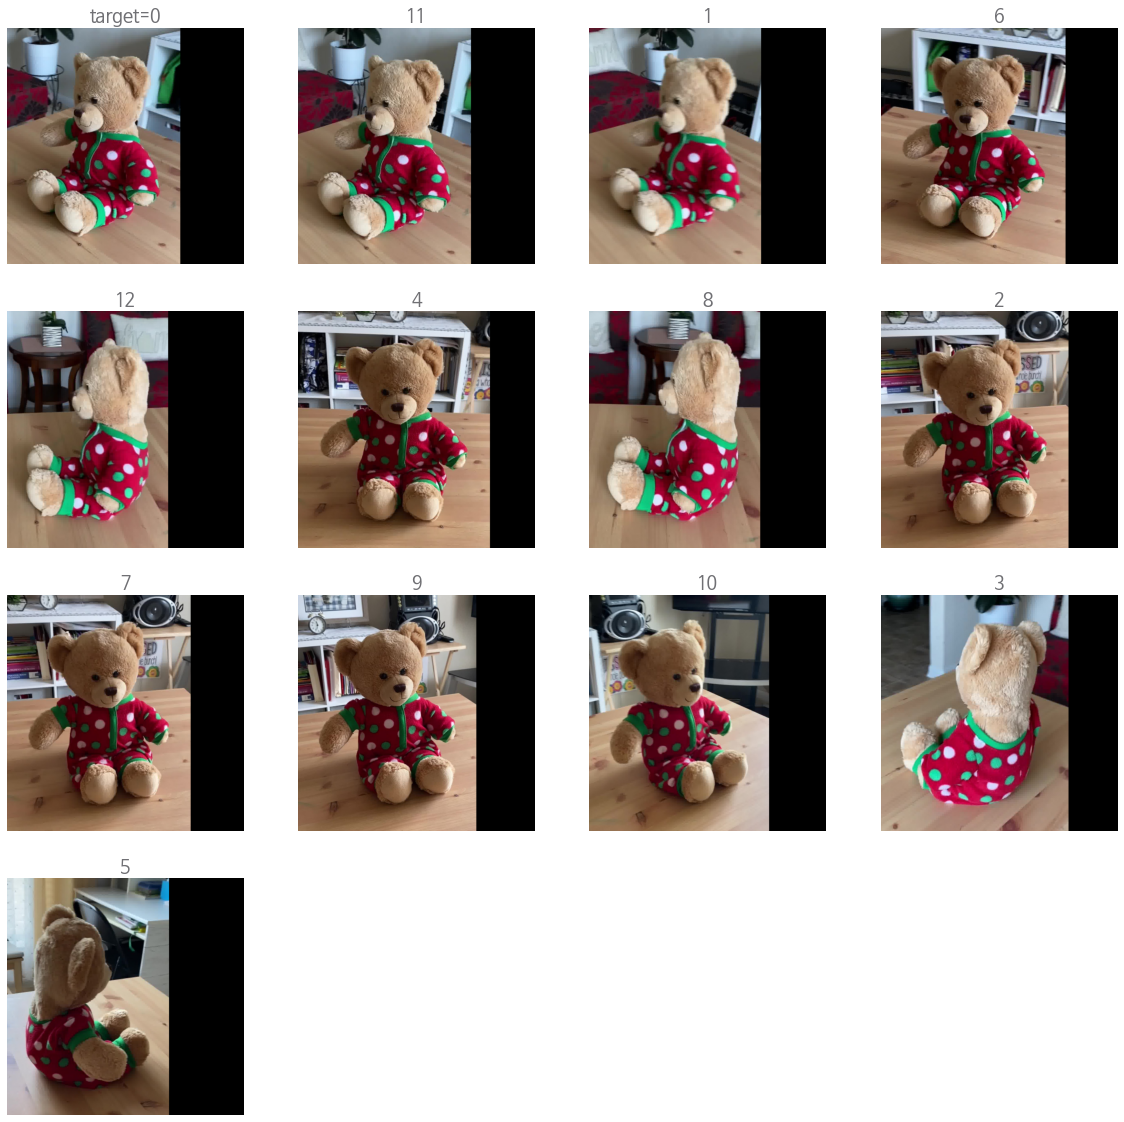

In [12]:
src_idxs = get_nearest_src(tgt_c2w, src_c2ws, 12, angular_dist_method="vector") + 1

print(src_idxs)

plt.figure(figsize=(20, 20))

tgt_img = rgbs[tgt_idx]
src_imgs = rgbs[src_idxs]

plt.subplot(4, 4, 1)
plt.title("target=0")
img = tgt_img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.axis("off")

for i, src_img in enumerate(src_imgs):
    plt.subplot(4, 4, 2 + i)
    plt.title(src_idxs[i].item())
    img = src_img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


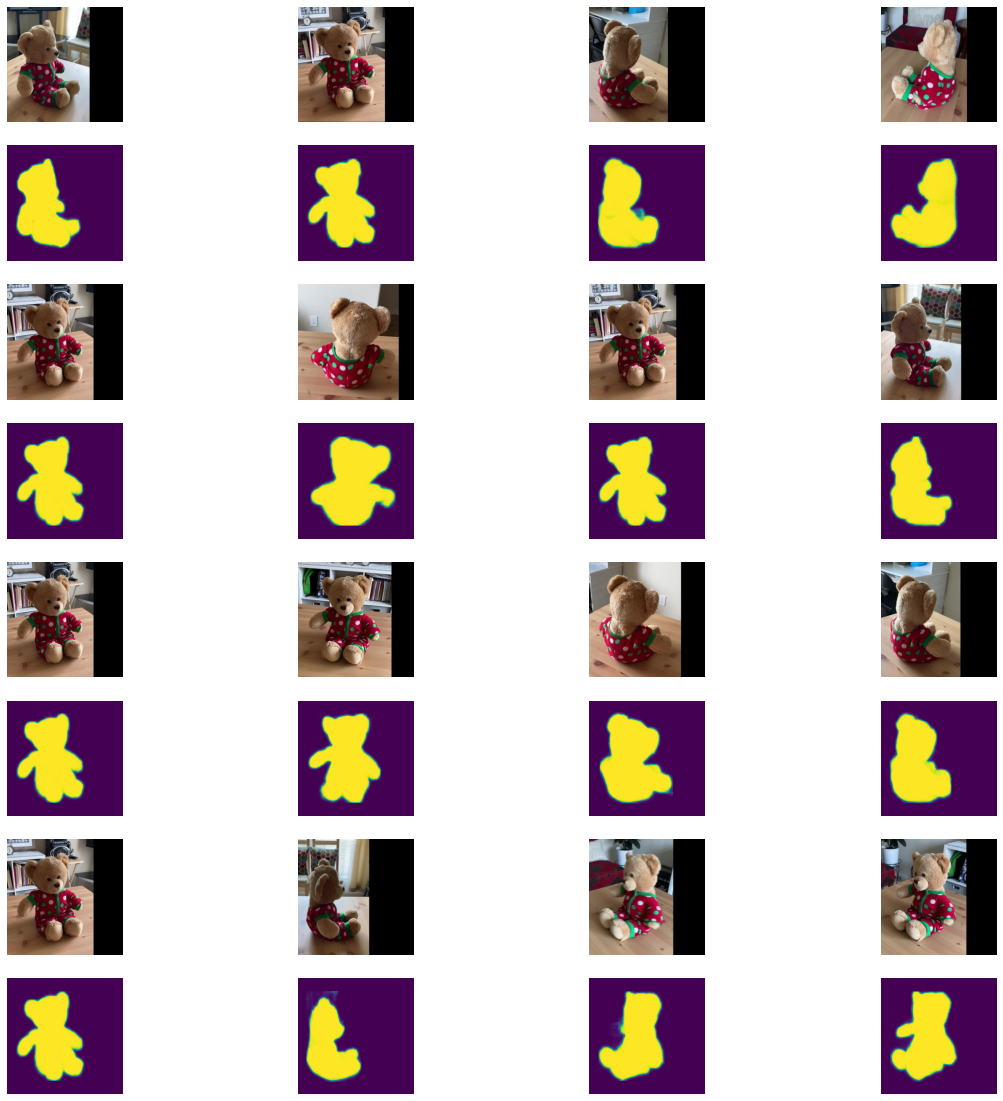

In [54]:
plt.figure(figsize=(20, 20))

for idx, data in enumerate(train_loader):
    imgs = data.image_rgb
    masks = data.fg_probability
    
    for i, (img, mask) in enumerate(zip(imgs, masks)):
        plt.subplot(8, 4, 8*idx + (i + 1))
        img = img.numpy().transpose(1, 2, 0)
        plt.imshow(img)
        plt.axis("off")

        plt.subplot(8, 4, 8*idx + (i + 1) + 4)
        mask = mask.numpy().transpose(1, 2, 0)
        plt.imshow(mask)
        plt.axis("off")

    if idx == 3:
        break

## Model 객체 생성

In [6]:
resnet_feature_dim = 32 * 3
rgb_dim = 3
segemtation_dim = 1
pe_dim = args.pe_dim

d_z = resnet_feature_dim + rgb_dim + segemtation_dim + pe_dim*2*3
print(f"D_z: {d_z}")

D_z: 160


In [7]:
load = torch.load("./out/1214_nearest_src_views/model_030000.pth")

net = NerFormerArchitecture(d_z=d_z).to(args.device)
net.load_state_dict(load['net'])

<All keys matched successfully>

In [7]:
net = NerFormerArchitecture(d_z=d_z).to(device)

In [8]:
feature_net = FeatureNetArchitecture().to(args.device)

In [58]:
!nvidia-smi

Mon Dec  6 12:14:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:60:00.0 Off |                  N/A |
| 27%   31C    P2    52W / 250W |   7254MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Criterion

In [9]:
mse_loss = nn.MSELoss(reduction="sum")         # target RGB <-> GT RGB
bce_loss = nn.BCELoss(reduction="sum")         # target Mask <-> GT Mask

tb_dir = os.path.join(args.root_dir, 'logs/', args.exp_name)
writer = SummaryWriter(tb_dir)
print('saving tensorboard files to {}'.format(tb_dir))

scalars_to_log = {}

saving tensorboard files to ./logs/1214_nearest_src_views


In [10]:
# n_iters = args.n_iters
n_iters = 50000
global_step = 0
epoch = 0

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=args.lr)

In [12]:
PE = HarmonicEmbedding(n_harmonic_functions=pe_dim).to(device)
args["PE"] = PE

while global_step < n_iters + 1:
    for train_data in train_loader:
        time0 = time.time()
        
        ##################### target, source data frame 구성 #####################
        target, srcs, src_idxs = data_to_frame(train_data, device, args)

        ######################## source feature map 구성 ########################
        with torch.no_grad():
            feature_maps = feature_net(srcs["rgb"], srcs["mask"])

        # ray sampler 생성
        ray_sampler = RaySampler(target, target_cam_idx=0, device=device, args=args)
        # 타겟 이미지에서 N_rays개의 ray 샘플링
        ray_batch = ray_sampler.random_sample(args.N_rays, args.ray_sampling_mode)

        output = render_rays(ray_batch, net, net, feature_maps, src_idxs, args)

        optimizer.zero_grad()

        coarse_rgb_loss = mse_loss(output["outputs_coarse"]["rgb"], ray_batch["rgb"])
        # coarse_mask_loss = bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])

        coarse_loss = coarse_rgb_loss

        fine_rgb_loss = mse_loss(output["outputs_fine"]["rgb"], ray_batch["rgb"])
        # fine_mask_loss = bce_loss(output["outputs_fine"]["mask"][..., 0], ray_batch["mask"])

        fine_loss = fine_rgb_loss

        total_loss = coarse_loss + fine_loss
        total_loss.backward()

        scalars_to_log['loss'] = total_loss.item()
        
        optimizer.step()

        dt = time.time() - time0

        # loss 출력
        if global_step % args.log_loss == 0 or global_step < 10:
            scalars_to_log['train/coarse-rgb-loss'] = coarse_rgb_loss
            # scalars_to_log['train/coarse-mask-loss'] = coarse_mask_loss

            if output['outputs_fine'] is not None:
                scalars_to_log['train/fine-rgb-loss'] = fine_rgb_loss
                # scalars_to_log['train/fine_mask_loss'] = fine_mask_loss

            logstr = '{} Epoch: {}  step: {} '.format(args.exp_name, epoch, global_step)
            for k in scalars_to_log.keys():
                logstr += ' {}: {:.6f}'.format(k, scalars_to_log[k])
                writer.add_scalar(k, scalars_to_log[k], global_step)
            print(logstr)
            print('each iter time {:.05f} seconds'.format(dt))

        # checkpoint 저장
        if global_step % args.log_weight == 0:
            print(f"Step[{global_step+1}/{n_iters}]: Checkpoint 저장...")
            save_path = os.path.join(out_folder, "model_{:06d}.pth".format(global_step))

            to_save = {
                        'optimizer': optimizer.state_dict(),
                        'net': net.state_dict(),
                        }
            torch.save(to_save, save_path)

        # validation 시각화 저장
        if global_step % args.log_img == 0:
            ######################## current training data ########################
            print(f"Step[{global_step+1}/{n_iters}]: Training data 결과 저장...")

            # train ray sampler 생성
            train_ray_sampler = RaySampler(target, target_cam_idx=0, device=device, args=args)
            H, W = train_ray_sampler.H, train_ray_sampler.W
            train_gt_img = train_ray_sampler.rgb.reshape(H, W, 3)
            train_gt_mask = train_ray_sampler.mask.reshape(H, W, 1)
            # # log
            log_view_to_tensorboard(args, writer, global_step, net, train_ray_sampler, feature_maps,
                                   srcs, src_idxs, train_gt_img, train_gt_mask, prefix='train/')

            ######################## random validation data ########################
            print(f"Step[{global_step+1}/{n_iters}]: Validation data 결과 저장...")

            val_data = next(iter(val_loader))
            #  validation target, source data frame 구성 
            val_target, val_srcs, val_src_idxs = data_to_frame(val_data, device, args)

            with torch.no_grad():
                val_feature_maps = feature_net(val_srcs["rgb"], val_srcs["mask"])

            # validation ray sampler 생성
            val_ray_sampler = RaySampler(val_target, target_cam_idx=0, device=device, args=args)
            H, W = val_ray_sampler.H, val_ray_sampler.W
            val_gt_img = val_ray_sampler.rgb.reshape(H, W, 3)
            val_gt_mask = train_ray_sampler.mask.reshape(H, W, 1)
            # log
            log_view_to_tensorboard(args, writer, global_step, net, val_ray_sampler, val_feature_maps,
                                   val_srcs, val_src_idxs, val_gt_img, val_gt_mask, prefix='val/')

        global_step += 1

        if global_step > n_iters + 1:
            break
        
    epoch += 1

1214_nearest_src_views Epoch: 0  step: 0  loss: 1049.864014 train/coarse-rgb-loss: 523.457153 train/fine-rgb-loss: 526.406921
each iter time 1.10090 seconds
Step[1/50000]: Checkpoint 저장...
Step[1/50000]: Training data 결과 저장...
Step[1/50000]: Validation data 결과 저장...
1214_nearest_src_views Epoch: 0  step: 1  loss: 874.511108 train/coarse-rgb-loss: 437.077087 train/fine-rgb-loss: 437.434021
each iter time 0.33367 seconds
1214_nearest_src_views Epoch: 0  step: 2  loss: 666.543335 train/coarse-rgb-loss: 332.691833 train/fine-rgb-loss: 333.851501
each iter time 0.33198 seconds
1214_nearest_src_views Epoch: 0  step: 3  loss: 853.448792 train/coarse-rgb-loss: 427.160553 train/fine-rgb-loss: 426.288239
each iter time 0.40798 seconds
1214_nearest_src_views Epoch: 0  step: 4  loss: 606.741455 train/coarse-rgb-loss: 303.530945 train/fine-rgb-loss: 303.210510
each iter time 0.33000 seconds
1214_nearest_src_views Epoch: 0  step: 5  loss: 567.637756 train/coarse-rgb-loss: 284.090149 train/fine-rgb-l

In [13]:
co3d_data = next(iter(train_loader))

In [16]:
imgs = co3d_data.image_rgb.type(torch.float32)
img_paths = co3d_data.image_path
masks = co3d_data.fg_probability.type(torch.float32)
camera = co3d_data.camera.type(torch.float32)

c2ws = camera.get_world_to_view_transform().inverse().get_matrix()
tgt_idx = 0
tgt_c2w = c2ws[tgt_idx]
src_c2ws = c2ws[1:]
src_idxs = get_nearest_src_test(tgt_c2w, src_c2ws, args.N_src) + 1

target = {}
target["rgb"] = imgs[tgt_idx].to(device)
target["rgb_path"] = img_paths[tgt_idx]
target["mask"] = masks[tgt_idx].to(device)
target["camera"] = camera.to(device)

tensor([-3.1266, -7.4316,  5.1198], dtype=torch.float64) tensor([-0.3274, -0.7781,  0.5361], dtype=torch.float64) torch.Size([12, 3])
tensor([ 3.8837, -0.3991, -9.5670], dtype=torch.float64) tensor([ 0.3759, -0.0386, -0.9259], dtype=torch.float64) torch.Size([12, 3])


In [15]:
target.to(device)

AttributeError: 'dict' object has no attribute 'to'

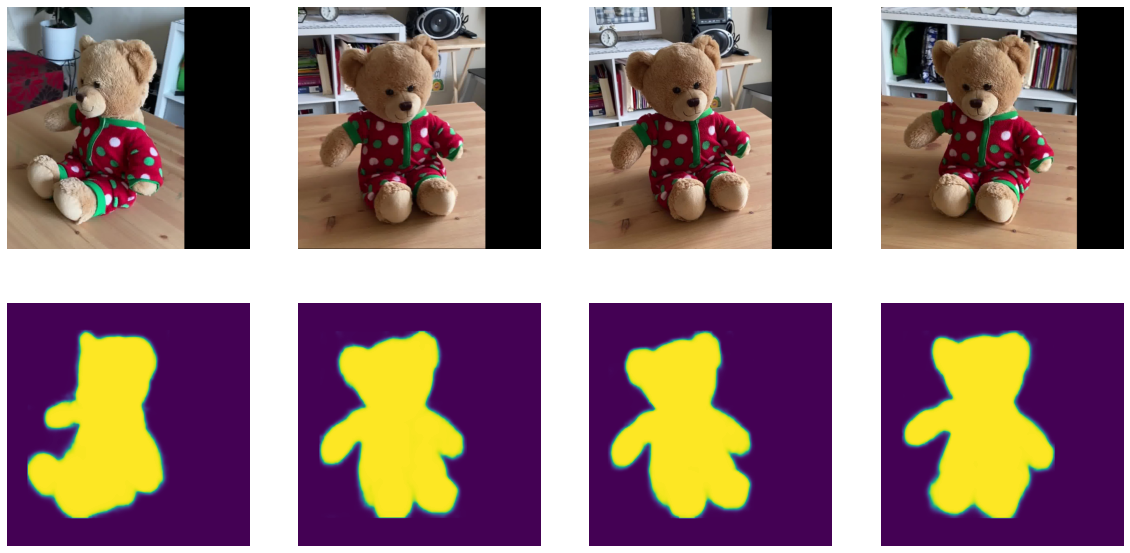

In [26]:
plt.figure(figsize=(20, 10))

img = target["rgb"].cpu()
mask = target["mask"].cpu()

plt.subplot(2, 4, 1)
img = img.numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.axis("off")

plt.subplot(2, 4, 5)
mask = mask.numpy().transpose(1, 2, 0)
plt.imshow(mask)
plt.axis("off")

imgs = srcs["rgb"].cpu()
masks = srcs["mask"].cpu()

for i, (img, mask) in enumerate(zip(imgs, masks)):
    plt.subplot(2, 4, 2 + i)
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(2, 4, 2 + i + 4)
    mask = mask.numpy().transpose(1, 2, 0)
    plt.imshow(mask)
    plt.axis("off")

In [9]:
from point_sampling import sample_along_camera_ray
from rendering import feature_sampling, EARayMarching, sample_pdf

In [10]:
def EARayMarching_test(ray_densities, ray_colors, z_vals):
    # z_vals: (N_rays, N_samples)
    # ray_densities: (N_rays, N_samples, 1) --> network의 아웃풋. opacity라고 부르는 값. (=소멸계수. 빛이 가려지는 비율을 뜻함.)
    # ray_colors: (N_rays, N_samples, 3)

    # delta 계산
    delta = z_vals[..., 1:] - z_vals[..., :-1]      # (N_rays, N_samples-1)
    delta = torch.cat((delta, delta[..., -1:]), dim=-1)     # (N_rays, N_samples)

    # Transparency(투명도) 계산
    # density(=opacity) 증가 >> T 감소
    # density(=opacity) 감소 >> T 증가
    T = torch.exp(-delta * ray_densities[..., 0])   # (N_rays, N_samples)

    # alpha 계산
    alphas = 1 - T + 1e-10          # (N_rays, N_samples)

    # absorption 계산
    # i번째 샘플에 대해, (i-1)번째 샘플까지의 transparancy가 누적된 값
    # 첫 번째 항으로 1을 넣은 뒤, 마지막 항을 제외하고 누적곱
    ones = torch.ones(T.shape[0], 1).to(T.device)   # (N_rays, 1)
    T_ = torch.cat((ones, T[..., :-1]), dim=1)      # (N_rays, N_samples)
    absorption = torch.cumprod(T_, dim=1)  # (N_rays, N_samples)

    # weights 계산
    # alpha blending 역할.
    # importance sample을 추출하는 fine 단계에서 사용한다.
    weights = absorption * alphas           # (N_rays, N_samples)

    # color 계산
    colors = torch.sum(weights.unsqueeze(2) * ray_colors, dim=-2)    # (N_rays, 3)
    # 0. ~ 1. 사이로 clamping
    colors = torch.clamp(colors, min=0., max=1.)
    
    # mask 계산
    # implicit surface에 의해 빛이 흡수된 총량.
    # alpha value인 mask 값이 1이라는 것은 complete absorption 되었다는 뜻이다.
    # TODO
    # mask 값이 전부 1이 나오는데 그럼 저 torch.prod(...)의 값이 다 0이라는 거겠지...
    # 위에서 alphas 계산한 걸 보면 아주 1e-10을 더해주는데 여기에는 그게 없어서 그런 건가????
    masks = 1 - torch.prod((1 - T), dim=1, keepdim=True)  # (N_rays, 1)

    # depth 계산
    # z_vals을 weighted sum 한 것이 depth 값.
    depth = torch.sum(weights * z_vals, dim=-1)
    
    return {
            "rgb": colors, 
            "weights": weights, 
            "alphas": alphas,
            "mask": masks,
            "depth":depth,
            "T": T,
            }

In [14]:
PE = HarmonicEmbedding(n_harmonic_functions=pe_dim).to(args.device)

##################### target, source data frame 구성 #####################
train_data = next(iter(train_loader))
target, srcs, src_idxs = data_to_frame(train_data, args.device, args)

######################## source feature map 구성 ########################
with torch.no_grad():
        feature_maps = feature_net(srcs["rgb"], srcs["mask"])

# ray sampler 생성
ray_sampler = RaySampler(target, target_cam_idx=0, device=args.device, args=args)
# 타겟 이미지에서 N_rays개의 ray 샘플링
ray_batch = ray_sampler.random_sample(args.N_rays, args.ray_sampling_mode)


ret = {"outputs_coarse": None,
        "outputs_fine": None}
#################################################################################
################################## Coarse step ##################################
#################################################################################
N_samples = 32

coarse_pts, coarse_z_vals = sample_along_camera_ray(ray_batch["ray_o"], ray_batch["ray_d"], ray_batch["depth_range"],
                                        N_samples,
                                        inv_uniform=args.inv_uniform,
                                        det=args.det)
N_rays, N_samples = coarse_pts.shape[:2]
H, W = feature_maps.shape[-2:]

# Positional Embedding
positional_embedding = PE(coarse_pts)

# Input tensor 구성
input_tensor = feature_sampling(feature_maps, ray_batch["camera"], coarse_pts, positional_embedding, (H, W), [1, 2, 3])

coarse_densities, coarse_colors = net(input_tensor)

outputs_coarse = EARayMarching_test(coarse_densities, coarse_colors, coarse_z_vals)

In [16]:
#################################################################################
################################### Fine step ###################################
#################################################################################
N_importance = 16

if N_importance > 0:
    # detach since we would like to decouple the coarse and fine networks
    weights = outputs_coarse['weights'].clone().detach()            # [N_rays, N_samples]
    
    if args.inv_uniform:
        print("inverse depth")
        inv_z_vals = 1. / coarse_z_vals
        inv_z_vals_mid = .5 * (inv_z_vals[:, 1:] + inv_z_vals[:, :-1])   # [N_rays, N_samples-1]
        weights = weights[:, 1:-1]      # [N_rays, N_samples-2]
        inv_z_vals = sample_pdf(bins=torch.flip(inv_z_vals_mid, dims=[1]),
                                weights=torch.flip(weights, dims=[1]),
                                N_samples=N_importance, det=args.det)  # [N_rays, N_importance]
        z_samples = 1. / inv_z_vals
    else:
        # take mid-points of depth samples
        z_vals_mid = .5 * (coarse_z_vals[:, 1:] + coarse_z_vals[:, :-1])   # [N_rays, N_samples-1]
        weights = weights[:, 1:-1]      # [N_rays, N_samples-2]
        z_samples = sample_pdf(bins=z_vals_mid, weights=weights,
                                N_samples=N_importance, det=args.det)  # [N_rays, N_importance]

    fine_z_vals = torch.cat((coarse_z_vals, z_samples), dim=-1)  # [N_rays, N_samples + N_importance]

    # samples are sorted with increasing depth
    fine_z_vals, _ = torch.sort(fine_z_vals, dim=-1)
    N_total_samples = N_samples + N_importance

    viewdirs = ray_batch['ray_d'].unsqueeze(1).repeat(1, N_total_samples, 1)
    ray_o = ray_batch['ray_o'].unsqueeze(1).repeat(1, N_total_samples, 1)
    fine_pts = fine_z_vals.unsqueeze(2) * viewdirs + ray_o  # [N_rays, N_samples + N_importance, 3]

    # Positional Embedding
    positional_embedding = PE(fine_pts)

    # Input tensor 구성
    input_tensor = feature_sampling(feature_maps, ray_batch["camera"], fine_pts, positional_embedding, (H, W), [1, 2, 3])

    fine_densities, fine_colors = net(input_tensor)
    outputs_fine = EARayMarching_test(fine_densities, fine_colors, fine_z_vals)

inverse depth


In [17]:
tgt_proj_points = target["camera"].transform_points_screen(coarse_pts.reshape(-1, 3), image_size=(H, W))[0].reshape(800, 32, 3)

In [18]:
img = target["rgb"].cpu().numpy().transpose(1, 2, 0)
print(img.shape)

(800, 800, 3)


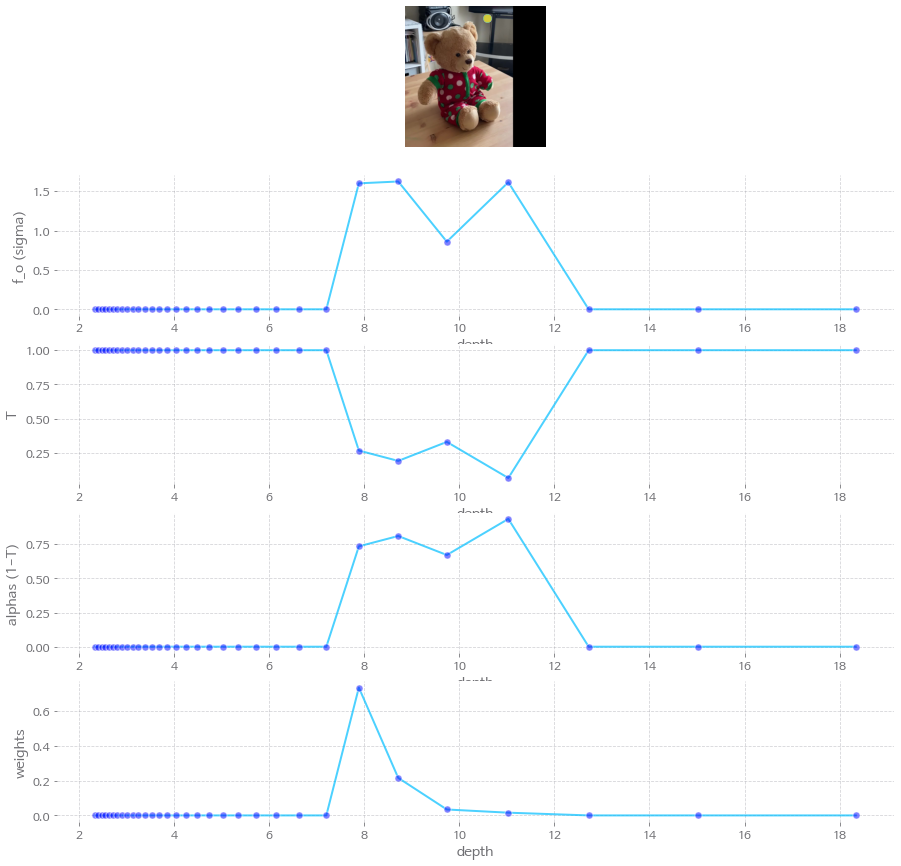

In [28]:
ray_idx = 1

plt.figure(figsize=(15, 15))
plt.title("Coarse Step")

proj_points = tgt_proj_points[ray_idx]
plt.subplot(5, 1, 1)
plt.imshow(img)
for point in proj_points[..., :2]:
    x = point[0].item()
    y = point[1].item()

    plt.scatter(x, y)
plt.axis("off")

depth = coarse_z_vals[ray_idx].cpu().numpy()

coarse_f_o = coarse_densities[ray_idx].squeeze(1).detach().cpu().numpy()
coarse_t = outputs_coarse["T"][ray_idx].detach().cpu().numpy()
coarse_alphas = outputs_coarse["alphas"][ray_idx].detach().cpu().numpy()
coarse_weights = outputs_coarse["weights"][ray_idx].detach().cpu().numpy()

plt.subplot(5, 1, 2)
plt.xlabel("depth")
plt.ylabel("f_o (sigma)")
plt.plot(depth, coarse_f_o, alpha=0.7, label=r'f_o')
plt.plot(depth, coarse_f_o, 'bo', alpha=0.5)

plt.subplot(5, 1, 3)
plt.xlabel("depth")
plt.ylabel("T")
plt.plot(depth, coarse_t, alpha=0.7, label=r'f_o')
plt.plot(depth, coarse_t, 'bo', alpha=0.5)

plt.subplot(5, 1, 4)
plt.xlabel("depth")
plt.ylabel("alphas (1-T)")
plt.plot(depth, coarse_alphas, alpha=0.7, label=r'f_o')
plt.plot(depth, coarse_alphas, 'bo', alpha=0.5)

plt.subplot(5, 1, 5)
plt.xlabel("depth")
plt.ylabel("weights")
plt.plot(depth, coarse_weights, alpha=0.7, label=r'f_o')
plt.plot(depth, coarse_weights, 'bo', alpha=0.5)


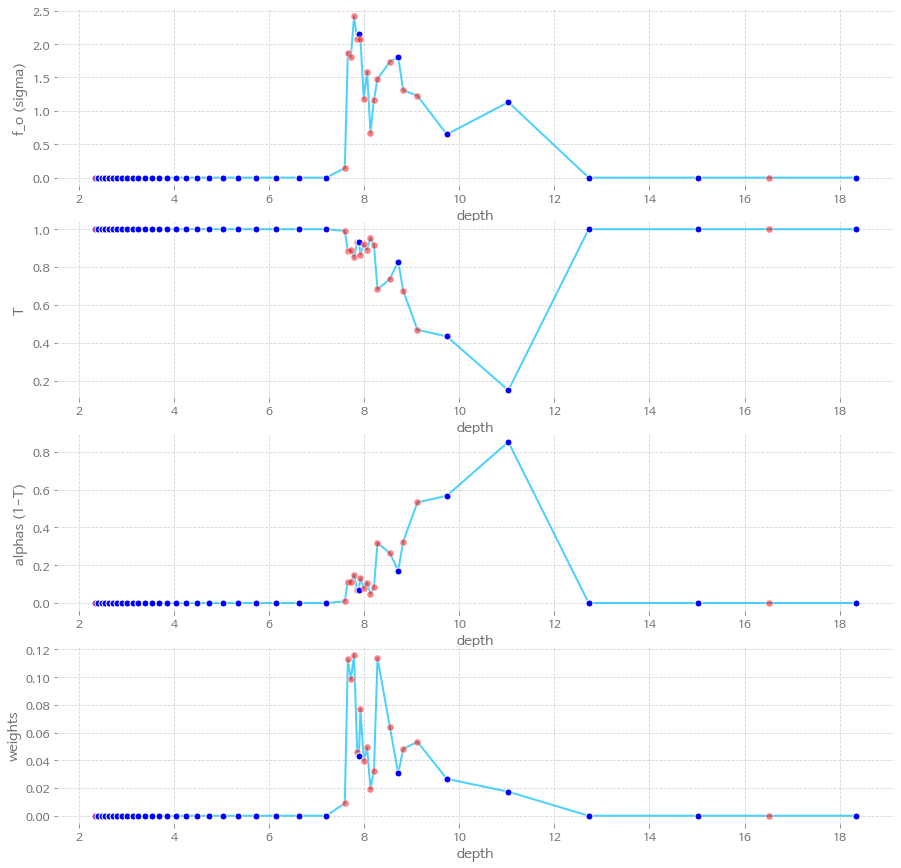

In [29]:
depth = fine_z_vals[ray_idx].cpu().numpy()

fine_f_o = fine_densities[ray_idx].squeeze(1).detach().cpu().numpy()
fine_t = outputs_fine["T"][ray_idx].detach().cpu().numpy()
fine_alphas = outputs_fine["alphas"][ray_idx].detach().cpu().numpy()
fine_weights = outputs_fine["weights"][ray_idx].detach().cpu().numpy()

plt.figure(figsize=(15, 15))
plt.title("Fine Step")

plt.subplot(4, 1, 1)
plt.xlabel("depth")
plt.ylabel("f_o (sigma)")
plt.plot(depth, fine_f_o, alpha=0.7, label=r'f_o')
for i, d in enumerate(depth):
    if d in z_samples:
        plt.plot(d, fine_f_o[i], 'ro', alpha=0.5)
    else:
        plt.plot(d, fine_f_o[i], 'bo', alpha=1.0)

plt.subplot(4, 1, 2)
plt.xlabel("depth")
plt.ylabel("T")
plt.plot(depth, fine_t, alpha=0.7, label=r'f_o')
for i, d in enumerate(depth):
    if d in z_samples:
        plt.plot(d, fine_t[i], 'ro', alpha=0.5)
    else:
        plt.plot(d, fine_t[i], 'bo', alpha=1.0)


plt.subplot(4, 1, 3)
plt.xlabel("depth")
plt.ylabel("alphas (1-T)")
plt.plot(depth, fine_alphas, alpha=0.7, label=r'f_o')
for i, d in enumerate(depth):
    if d in z_samples:
        plt.plot(d, fine_alphas[i], 'ro', alpha=0.5)
    else:
        plt.plot(d, fine_alphas[i], 'bo', alpha=1.0)


plt.subplot(4, 1, 4)
plt.xlabel("depth")
plt.ylabel("weights")
plt.plot(depth, fine_weights, alpha=0.7, label=r'f_o')
for i, d in enumerate(depth):
    if d in z_samples:
        plt.plot(d, fine_weights[i], 'ro', alpha=0.5)
    else:
        plt.plot(d, fine_weights[i], 'bo', alpha=1.0)



In [36]:
pts, z_vals_inv_true = sample_along_camera_ray(ray_batch["ray_o"], ray_batch["ray_d"], ray_batch["depth_range"],
                                            32,
                                            inv_uniform=True,
                                            det=args.det)

pts, z_vals_inv_false = sample_along_camera_ray(ray_batch["ray_o"], ray_batch["ray_d"], ray_batch["depth_range"],
                                            32,
                                            inv_uniform=False,
                                            det=args.det)

In [37]:
print(z_vals_inv_true[0])
print(z_vals_inv_false[0])

tensor([ 1.8309,  1.8855,  1.9434,  2.0050,  2.0707,  2.1408,  2.2157,  2.2962,
         2.3827,  2.4759,  2.5768,  2.6862,  2.8054,  2.9356,  3.0784,  3.2359,
         3.4104,  3.6047,  3.8226,  4.0684,  4.3481,  4.6691,  5.0412,  5.4777,
         5.9971,  6.6252,  7.4003,  8.3808,  9.6609, 11.4024, 13.9098, 17.8309],
       device='cuda:0')
tensor([ 1.8309,  2.3471,  2.8632,  3.3793,  3.8954,  4.4116,  4.9277,  5.4438,
         5.9600,  6.4761,  6.9922,  7.5083,  8.0245,  8.5406,  9.0567,  9.5729,
        10.0890, 10.6051, 11.1212, 11.6374, 12.1535, 12.6696, 13.1858, 13.7019,
        14.2180, 14.7341, 15.2503, 15.7664, 16.2825, 16.7987, 17.3148, 17.8309],
       device='cuda:0')


In [38]:
delta_inv_true = z_vals_inv_true[..., 1:] - z_vals_inv_true[..., :-1]
delta_inv_true = torch.cat((delta_inv_true, delta_inv_true[..., -1:]), dim=-1)
print(delta_inv_true[0])

delta_inv_false = z_vals_inv_false[..., 1:] - z_vals_inv_false[..., :-1]
delta_inv_false = torch.cat((delta_inv_false, delta_inv_false[..., -1:]), dim=-1)
print(delta_inv_false[0])

tensor([0.0546, 0.0579, 0.0616, 0.0656, 0.0701, 0.0750, 0.0804, 0.0865, 0.0933,
        0.1009, 0.1094, 0.1191, 0.1302, 0.1429, 0.1575, 0.1745, 0.1944, 0.2178,
        0.2459, 0.2797, 0.3210, 0.3721, 0.4366, 0.5193, 0.6281, 0.7751, 0.9805,
        1.2800, 1.7415, 2.5074, 3.9211, 3.9211], device='cuda:0')
tensor([0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161,
        0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161,
        0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161, 0.5161,
        0.5161, 0.5161, 0.5161, 0.5161, 0.5161], device='cuda:0')


In [165]:
from rendering import feature_sampling

In [170]:
positional_embedding = args.PE(pts)
input_tensor = feature_sampling(feature_maps, ray_batch["camera"], pts, positional_embedding, (H, W), [1, 2, 3])
coarse_densities, coarse_colors = net(input_tensor)

In [197]:
print(coarse_colors.min(), coarse_colors.max())
colors_clamp = torch.clamp(coarse_colors, min=0., max=1.)
print(colors_clamp.min(), colors_clamp.max())

tensor(-0.4099, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.5011, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


In [21]:
output["outputs_fine"]["mask"][..., 0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 

In [91]:
bce_loss_sum = nn.BCELoss(reduction="sum")

In [108]:
x = torch.tensor([0.001])
y = torch.tensor([1])

print(y*torch.log(x) + (1-y)*torch.log(1-torch.log(x)))

tensor([-6.9078])


In [128]:
bce_loss_sum(output["outputs_fine"]["mask"][0, 0], ray_batch["mask"][0])

tensor(100., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [ ]:
bce_loss_sum(output["outputs_fine"]["mask"][, 0], ray_batch["mask"][0])

In [79]:
bce_loss.reduction

'mean'

In [70]:
print(coarse_mask_loss)
print(fine_mask_loss)

tensor(4.3101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(71.9328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [68]:
bce_loss(output["outputs_coarse"]["mask"][..., 0], ray_batch["mask"])

tensor(4.3101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)

In [32]:
torch.cuda.empty_cache()

In [22]:
train_ray_sampler.rgb.shape

torch.Size([640000, 3])

In [26]:
print(train_ray_sampler.mask.shape)

print(train_ray_sampler.mask.reshape(H, W, 1).shape)

torch.Size([640000])
torch.Size([800, 800, 1])


In [19]:
output["outputs_coarse"].keys()

dict_keys(['rgb', 'weights', 'alphas', 'mask'])

In [20]:
output["outputs_coarse"]["rgb"].shape

torch.Size([800, 3])